# Predict team using defect title (Linear model)

in the following notebook, a model is built and trained using defects data from center. 
for predicting one field from defects form - team field.

## Required libraries
general imports - keras, sklearn, numpy, pandas

In [118]:
import keras 
from keras.models import Sequential
from sklearn.linear_model import LogisticRegression
from keras.layers import Activation
from keras.optimizers import Adam
from keras import regularizers
from keras.layers import Dense, GlobalAveragePooling1D, Embedding, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn import metrics
from keras.metrics import categorical_crossentropy
from sklearn.model_selection import train_test_split
import pandas as pd
import json
import numpy as np
import os
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# load data from dataset

In [119]:
# Reads and converts json / Excel format to python dict.
def js_r(data):
   with open(data, encoding='utf-8') as f_in:
       return(json.load(f_in))

def read_excel(path):
    return pd.read_excel(open(path, 'rb'),
                  sheet_name='Sheet2')  # doctest: +SKIP

# load JSON data
# data_path=r'C:\dev\defects.json'
# my_dic_data = js_r(data_path)['data']

# Load EXCEL data:
data_path = r'datasets' + os.sep + 'defects-all-spread.xlsx'
my_dic_data = read_excel(data_path)
print('There are: ' + str(len(my_dic_data)) + ' records of defects in dataset.')

There are: 28970 records of defects in dataset.


# Clean the dataset

handling ids fields from json dataset, remove unused columns

In [120]:
def transform_data(data_list):
    print(len(data_list))
    for defect in my_dic_data:
        for column in defect.keys():
            if not defect[column] == None and type(defect[column]) is dict and 'id' in defect[column]:
                defect[column] = defect[column]['id']
        
    return pd.DataFrame(my_dic_data).drop(['access_granted', 'blocked_reason', 'path', 'phase',
                                           'blocked', 'original_id', 'priority', 'defect_root_level', 'story_points', 'user_tags', 'program', 'taxonomies', 'version_stamp', 'detected_in_build', 'sprint', 'dependency_problem_type', 'defect_type'], axis=1)
# df = transform_data(my_dic_data)

cleaning the dataset (removing defects without labels, defects with only one label)

In [121]:
# build dataframe from dict
df = pd.DataFrame(my_dic_data)
# cleaning rows without labels OR descritpion
df = df[df['team.id'].map(lambda x: x != None)]
df = df[df['name'].map(lambda x: x != None)]
train_df = df[df['description'].map(lambda x: x != None)]
print("Original dataset shape is: " + str(train_df.shape))

# minimize data set
train_df = train_df[train_df['creation_time'].map(lambda x: x.year >= 2018)]
train_df = train_df.groupby('team.id').filter(lambda x : len(x)>2)
print("Small dataset shape is: " + str(train_df.shape))

# building translation map from team id -> team name
team_id_to_name_map = pd.Series(df['team.name'].values,index=df['team.id']).to_dict()
# spliting Lables from features
X = train_df.drop(['team.id'], axis=1)
Y = train_df['team.id']

train_df.head(n=2)

Original dataset shape is: (28970, 18)
Small dataset shape is: (11519, 18)


,creation_time,id,name,description,knowledge_modified_udf,parent.name,parent.id,release.id,team.id,team.name,product_areas.id,product_areas.name,application_modules.id,application_modules.name,qa_owner.id,qa_owner.name,owner.id,owner.name
8,2018-02-14 14:54:39,572045,"[center] in team backlog storyboard, card size...",&lt;html&gt;&lt;body&gt;&lt;p&gt;&lt;span styl...,NaT,Requirement Backlog,1001,54001.0,9005.0,Ehud - Guardians,77009.0,09 Team Backlog,77009.0,09 Team Backlog,162002.0,channa.even-chen@microfocus.com,NaN,NaN
9,2019-04-04 12:05:17,828009,The message that explains why upgrade is prev...,&lt;html&gt;&lt;body&gt;&lt;div style=&quot;di...,NaT,[tech][On-premise] Prevent site upgrade in cas...,768060,69001.0,9004.0,Neva - Avengers,110001.0,ElasticSearch,110001.0,ElasticSearch,35001.0,tal@microfocus.com,11001.0,liat.orshizer@microfocus.com


# Know the data

### Team defect distribution

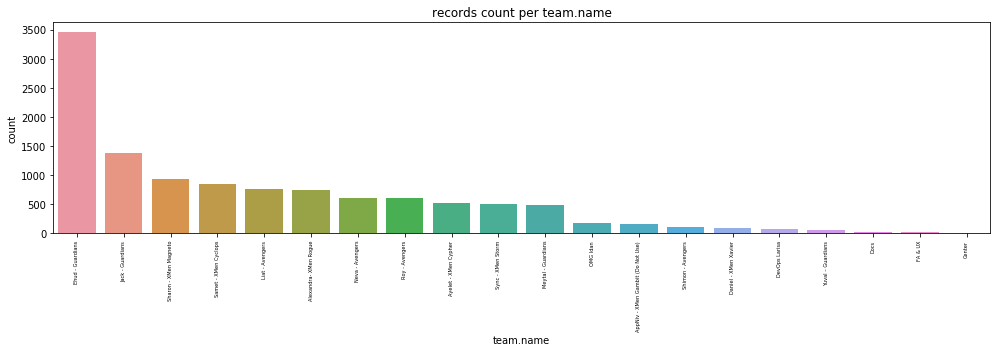

In [122]:
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
all_labels_image_name = 'gifs' + os.sep + 'team_bar_plot.pdf'

def author_bar_plot(train_df, column):
    fig = plt.gcf()
    fig.set_size_inches(14, 5)
    sns.countplot(x=train_df[column], order=train_df[column].value_counts().index).set_title(
        'records count per ' + column)
    plt.xticks(rotation='vertical', fontsize=5)
    fig.tight_layout()
    fig.savefig(all_labels_image_name, format='pdf')
    plt.close()
    return fig
    
author_bar_plot(train_df, 'team.name')

as we have 6K documents labeled for Ehud team, a majority classifier score will be 6000 / 28K == 20% Accuracy!

### Frequent words

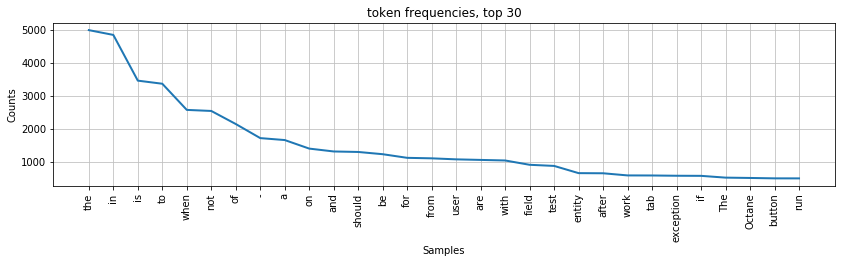

In [123]:
all_tokens_image_name = 'gifs' + os.sep + 'team_token_plot.pdf'
def plot_token_frequencies(train_df, referance_column='name', title_prefix='',
                           output_path=all_tokens_image_name):
    fig = plt.gcf()
    fig.set_size_inches(14, 3)
    fd = nltk.FreqDist([y for x in train_df[referance_column].str.split() for y in x])
    if title_prefix != '':
        title = title_prefix + ',token frequencies, top 30'
    else:
        title = 'token frequencies, top 30'

    fd.plot(30, title=title)
    fig.savefig(output_path + 'plot_token_frequencies_' + title_prefix + '.pdf', format='pdf')
    plt.close()


plot_token_frequencies(train_df)


# Data preparation

labels encoding

In [124]:
# label envoding
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
le = LabelEncoder()
encoded_labels = pd.DataFrame(le.fit_transform(train_df['team.id']))
classes_number = encoded_labels.groupby(0).nunique().shape[0]
all_labels = encoded_labels[0].unique()
print('there are: ' + str(classes_number) + ' different labels in dataset, which corresponds to all teams')

there are: 20 different labels in dataset, which corresponds to all teams


In [125]:
# ensure that the model is not overfitting 
# train & validation tests with labels, test without
xtrain, xvalid, ytrain, yvalid = train_test_split(train_df['name'], encoded_labels,
                                                      stratify=encoded_labels,
                                                      random_state=42,
                                                      test_size=0.2, shuffle=True)


print ('train samples: ' + str(xtrain.shape) + ' validation samples: ' + str(xvalid.shape))

train samples: (9215,) validation samples: (2304,)


# Extract features

In [126]:
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter

class PosTagMatrix(BaseEstimator, TransformerMixin):
    #normalise = True - devide all values by a total number of tags in the sentence
    #tokenizer - take a custom tokenizer function
    def __init__(self, tokenizer=lambda x: x.split(), normalize=True):
        self.tokenizer=tokenizer
        self.normalize=normalize

    #helper function to tokenize and count parts of speech
    def pos_func(self, sentence):
        return Counter(tag for word,tag in nltk.pos_tag(self.tokenizer(sentence)))

    # fit() doesn't do anything, this is a transformer class
    def fit(self, X, y = None):
        return self

    #all the work is done here
    def transform(self, X):
        X_tagged = X.apply(self.pos_func).apply(pd.Series).fillna(0)
        X_tagged['n_tokens'] = X_tagged.apply(sum, axis=1)
        if self.normalize:
            X_tagged = X_tagged.divide(X_tagged['n_tokens'], axis=0)

        return X_tagged

In [127]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# pipe2 = Pipeline([
#     ('u1', FeatureUnion([
#         ('tfdif_features', Pipeline([
#             ('cv', CountVectorizer()),
#             ('tfidf', TfidfTransformer()),
#         ])),
#         ('pos_features', Pipeline([
#             ('pos', PosTagMatrix(tokenizer=nltk.word_tokenize) ),
#         ])),
#     ])),
#     ('logit', LogisticRegression()),

# ])


In [128]:
# Fitting the Model
# Our pipe1 object has all the properties of an estimator, so we can treat it as such. Hence, we call the fit() method.

# Note that Pipeline "knows" that the first tho steps are transformers, so it will only call fit() and transform() on them, or just fit_transform() if it's defined for the class. For the LogisticRegression instance - our final model - only fit() will be called.
# pipe1.fit(xtrain, ytrain)
# pipe1.steps

# Train & Evaluate validation set

In [129]:
from sklearn.metrics import log_loss

# pred = pipe1.predict_proba(xvalid)
# xxx = pipe1.predict(xvalid)
# log_loss(yvalid, pred)



In [130]:
#set_params(cv__lowercase=True)
# pipe1.set_params(cv__min_df=6, 
#                  cv__lowercase=False).fit(xtrain, ytrain)
# pred = pipe1.predict_proba(xvalid)
# predictions_classes = pipe1.predict(xvalid)
# print ("log loss: " + str(log_loss(yvalid, pred)))
# print("accuracy: %0.3f" % (np.sum(predictions_classes == yvalid[0]) / len(yvalid[0])))


In [131]:
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
import pandas as pd


class CustomItemSelector(BaseEstimator, TransformerMixin):

    def __init__(self, df, index):
        self.index = index
        self.df = df

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(self.df[:, self.index])


class ItemSelector(BaseEstimator, TransformerMixin):

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key].values
    
class DateTransformer(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return pd.DataFrame(x.apply(lambda x: (x.year % 2000) - 15))

In [132]:
from sklearn.decomposition import PCA as sklearnPCA, TruncatedSVD
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
word_dim_reduction = 1000


# date_pipeline = Pipeline([
#             ('selector', ItemSelector(key='creation_time')),
#             ('date_transformer', DateTransformer())
#         ])

# cv_pipeline = Pipeline([
#             ('sel', ItemSelector(key='name')),
#             ('cv', CountVectorizer(analyzer='word', token_pattern=r'\w{1,}',
#                           ngram_range=(1, 2), stop_words='english')),
#             ('svd', TruncatedSVD(n_components=word_dim_reduction))
#         ])

tfv = TfidfVectorizer(min_df=3,  max_features=None,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

cv_pipeline = Pipeline([
            ('tfidf', tfv),
            ('svd', decomposition.TruncatedSVD(n_components=200)),
            ('scale', preprocessing.StandardScaler())
        ])

xtrain_svd_scl  = cv_pipeline.fit_transform(xtrain, ytrain)

# scl = preprocessing.StandardScaler()
# scl.fit(xtrain_svd)
# xtrain_svd_scl = scl.transform(xtrain_svd)
# xvalid_svd_scl = scl.transform(xvalid_svd)

# combined_features = FeatureUnion([
#             ("text_count_vectorizer_data", cv_pipeline)
# ])


# transform validation
xvalid_svd_scl  = cv_pipeline.transform(xvalid)

clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)
predictions_classes = clf.predict(xvalid_svd_scl)


# classifier = LogisticRegression(solver='sag', C=10)
# classifier.fit(X_train_word_features, ytrain)
# y_pred = classifier.predict(test_features)
# y_pred_prob = classifier.predict_proba(test_features)[:, 1]
print("done training...")

C:\Users\vaingato.CORPDOM\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


done training...


In [133]:
print("Logistic regression measures:")
print("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))
print("accuracy: %0.3f" % (np.sum(predictions_classes == yvalid[0]) / len(yvalid[0])))

Logistic regression measures:
logloss: 0.873 
accuracy: 0.748


# predict team by defect name

In [134]:
def predict_by_string(string_to_predict):
    column = pd.Series(np.array([string_to_predict])) 
    print(column.shape)
    scaled_string = cv_pipeline.transform(column)
    y_class = clf.predict(scaled_string)
    print("y class: " + str(y_class))
    probabilities = clf.predict_proba(scaled_string)
    
    predicted_team_id = le.inverse_transform(y_class)[0]
    team_name = team_id_to_name_map[predicted_team_id]
    print (str(probabilities.max()) + " probability it's: " + team_name + " labeled by " + str(team_name))
    return predictions, predictions_classes
  

In [135]:
predict_by_string("elastic search upgrade")

(1,)
y class: [3]
0.8871577029577432 probability it's: Neva - Avengers labeled by Neva - Avengers


(array([[1.55803823e-03, 2.78231406e-04, 3.52584876e-04, ...,
         3.64940967e-04, 3.76210099e-04, 6.22791971e-04],
        [5.44659386e-04, 1.76992210e-03, 1.53202196e-03, ...,
         3.10904282e-02, 2.23153338e-03, 4.20730315e-04],
        [5.66819471e-04, 2.84796012e-04, 6.21075922e-04, ...,
         5.16636813e-04, 4.13441260e-04, 4.90896167e-04],
        ...,
        [1.23083792e-05, 1.44149113e-05, 1.76164446e-05, ...,
         1.49650804e-05, 1.60003079e-05, 1.06555615e-05],
        [4.51251589e-03, 7.43087474e-03, 5.33404845e-03, ...,
         2.20864973e-02, 2.11057773e-02, 1.50801526e-03],
        [8.45485383e-01, 1.11666979e-02, 6.26764050e-02, ...,
         1.86851635e-03, 1.27116227e-03, 1.28337082e-03]]),
 array([13,  3, 13, ..., 13,  4,  0], dtype=int64))

array([ 8001.,  8003.,  9002.,  9004.,  9005.,  9007., 10001., 10002.,
       11002., 11004., 14006., 20001., 23001., 23002., 38001., 39001.,
       46001., 50001., 57001., 59001.])

# train test split: train, valid, test sets

## regularization

how to avoid overfitting
- reduce layers
- randomly neglect nodes from producing output in nn (dropout)
- add regularization (penelize for large weights: loss + x) L2 regularization

how to avoid underfitting - 
- encrease layers / nodes.
- add additional features.

to add regularization to layer:
model.add(Dense(5, input_shape=(26,), kernal.regulizer=regulizers.l2(0.01), activation='relu'))


# create the model with layers

In [137]:
model.summary()

NameError: name 'model' is not defined

# compile the module

# train the model

In [ ]:
print("done")